In [35]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"

# ! python -m pip install -q protobuf==4.25.1

# ! python -m pip install -q \
#   diffusers \
#   transformers \
#   safetensors \
#   sentencepiece \
#   accelerate \
#   mediapy \
#   einops \
#   imageio \
#   torchvision \
#   Pillow \
#   tqdm \
#   pandas \
#   better-profanity \
#   lpips

# ! python -m pip install -q ftfy regex tqdm
# ! python -m pip install -q git+https://github.com/openai/CLIP.git

! git clone https://github.com/Sriya613/visual_anagrams.git
! python -m pip install -q -e .

# import sys
# sys.path.append('/content/visual_anagrams')

from huggingface_hub import login
from diffusers import DiffusionPipeline, IFImg2ImgPipeline, IFSuperResolutionPipeline
from skimage.metrics import structural_similarity as ssim
from torchvision.transforms import InterpolationMode
from torchvision.transforms import functional as TF_1
from diffusers.utils.torch_utils import randn_tensor
from better_profanity import profanity
from torchvision import transforms
import torchvision.transforms as T
from tabulate import tabulate
import matplotlib.pyplot as plt
import torch.nn.functional as F
from einops import rearrange
import mediapy as mp
from tqdm import tqdm
import torch
from PIL import Image
import clip
import pandas as pd
import numpy as np
import itertools
import lpips
import math
import gc

from visual_anagrams.views.view_identity import IdentityView
from visual_anagrams.views.view_flip import FlipView
from visual_anagrams.views.view_rotate import Rotate180View, Rotate90CCWView, Rotate90CWView
from visual_anagrams.views.view_negate import NegateView
from visual_anagrams.views.view_skew import SkewView
from visual_anagrams.views.view_patch_permute import PatchPermuteView
from visual_anagrams.views.view_jigsaw import JigsawView
from visual_anagrams.views.view_inner_circle import InnerCircleView, InnerCircleViewFailure
from visual_anagrams.views.view_square_hinge import SquareHingeView
from visual_anagrams.views.view_blur import BlurViewFailure
from visual_anagrams.views.view_white_balance import WhiteBalanceViewFailure
from visual_anagrams.views.view_hybrid import (
    HybridLowPassView, HybridHighPassView,
    TripleHybridHighPassView, TripleHybridLowPassView,
    TripleHybridMediumPassView
)
from visual_anagrams.views.view_color import ColorView, GrayscaleView
from visual_anagrams.views.view_motion import MotionBlurResView, MotionBlurView
from visual_anagrams.views.view_scale import ScaleView
from visual_anagrams.animate import animate_two_view

Cloning into 'visual_anagrams'...
ERROR: file:///C:/Users/CSE07/Desktop/PW25_SSS_13/FINAL does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
token = "ENTER YOUR TOKEN HERE"
login(token=token)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\CSE07\.cache\huggingface\token
Login successful


In [37]:
# Try to import the repo's BaseView (absolute path). If running standalone in Colab,
# fall back to a plain object so the class still works.
try:
    from visual_anagrams.views.view_base import BaseView
except Exception:
    BaseView = object

In [38]:
def get_inv_perm(perm):
    return torch.argsort(perm)

# Garbage collection function to free memory
def flush():
    gc.collect()
    torch.cuda.empty_cache()

def im_to_np(im):
  im = (im / 2 + 0.5).clamp(0, 1)
  im = im.detach().cpu().permute(1, 2, 0).numpy()
  im = (im * 255).round().astype("uint8")
  return im

def resize_to_square_torch(image, target_size, method='pad'):
    width, height = image.size
    if method == 'pad':
        if width == height:
            pad_left = pad_right = pad_top = pad_bottom = 0
        elif width > height:
            pad_top = pad_bottom = (width - height) // 2
            pad_left = pad_right = 0
        else:
            pad_left = pad_right = (height - width) // 2
            pad_top = pad_bottom = 0

        transform_pad = transforms.Compose([
            transforms.Pad((pad_left, pad_top, pad_right, pad_bottom), fill=255, padding_mode='constant'),
            transforms.Resize((target_size, target_size), interpolation=InterpolationMode.BICUBIC)
        ])
        return transform_pad(image)

    elif method == 'crop':
        transform_crop = transforms.Compose([
            transforms.CenterCrop(min(width, height)),
            transforms.Resize((target_size, target_size), interpolation=InterpolationMode.BICUBIC)
        ])
        return transform_crop(image)

In [39]:
@torch.no_grad()
def img_sample_stage_1(
    model,
    prompt_embeds_text,           # (1, seq_len, dim) tensor
    negative_prompt_embeds_text,  # (1, seq_len, dim) tensor
    views,                        # list of view objects, length V
    images_per_view=None,         # list length V of PIL.Image or None
    num_inference_steps=100,
    guidance_scale=7.5,
    reduction='mean',
    strength=0.75,
    generator=None,
):
    """
    Debuggable Img2Img sampling for Visual Anagrams.
    - Signature unchanged from your last call site.
    - Supports at most one image-conditioned view (will be moved to index 0).
    - Prints shapes/dtypes at each step for debugging.
    """

    batch_size = 1
    num_images_per_prompt = 1
    V = len(views)

    # -------------------------------
    # Basic checks / dtypes
    # -------------------------------
    assert isinstance(prompt_embeds_text, torch.Tensor), "prompt_embeds_text must be a tensor"
    assert isinstance(negative_prompt_embeds_text, torch.Tensor), "negative_prompt_embeds_text must be a tensor"
    unet_dtype = model.unet.dtype

    # default: no image conditioning
    if images_per_view is None:
        images_per_view = [None] * V
    assert len(images_per_view) == V, "images_per_view must match number of views"

    # Reorder so that the image-conditioned view (if any) is first.
    image_indices = [i for i, im in enumerate(images_per_view) if im is not None]
    if len(image_indices) > 1:
        raise NotImplementedError("Only one image-conditioned view supported by this helper.")
    if len(image_indices) == 1 and image_indices[0] != 0:
        idx = image_indices[0]
        perm = [idx] + [i for i in range(V) if i != idx]
        views = [views[i] for i in perm]
        images_per_view = [images_per_view[i] for i in perm]

    # -------------------------------
    # Build per-view embeddings (pos/neg)
    # -------------------------------
    per_view_pos, per_view_neg = [], []
    for im in images_per_view:
        if im is None:
            # text-only view -> use the real text embeddings (positive)
            per_view_pos.append(prompt_embeds_text.squeeze(0))   # (seq_len, dim)
            per_view_neg.append(negative_prompt_embeds_text.squeeze(0))
        else:
            # image-conditioned view -> we put unconditional in the *positive* slot
            # so that cross-attention text guidance is disabled for this view.
            per_view_pos.append(negative_prompt_embeds_text.squeeze(0))
            per_view_neg.append(negative_prompt_embeds_text.squeeze(0))

    # Stack -> (V, seq_len, dim)
    pos_stack = torch.stack(per_view_pos, dim=0).to(device=device, dtype=unet_dtype)
    neg_stack = torch.stack(per_view_neg, dim=0).to(device=device, dtype=unet_dtype)
    # concat to shape (2*V, seq_len, dim) -> required by the UNet for classifier-free concat
    prompt_embeds = torch.cat([neg_stack, pos_stack], dim=0)
    print(f"[DEBUG] prompt_embeds: {prompt_embeds.shape}, dtype={prompt_embeds.dtype}")

    # -------------------------------
    # Timesteps
    # -------------------------------
    model.scheduler.set_timesteps(num_inference_steps, device=device)
    # timesteps = model.scheduler.timesteps
    # print(timesteps)
    timesteps, num_inference_steps = model.get_timesteps(num_inference_steps, strength)

    # -------------------------------
    # Initial noisy images (image-conditioned or pure noise)
    # -------------------------------
    if images_per_view[0] is not None:
        # First, resize to square to avoid distortion (using helper)
        ref_pil = images_per_view[0]  # PIL.Image
        target_size = 512  # Or dynamically: model.unet.config.sample_size * 8 (latent scale factor, e.g., 64*8=512)
        square_ref_pil = resize_to_square_torch(ref_pil, target_size, method='pad')

        # Now preprocess the square PIL to tensor (normalized for model)
        ref_im = model.preprocess_image(square_ref_pil).to(device=device, dtype=unet_dtype)  # (1, C, H, W)
        noise_timestep = timesteps[0:1].repeat(batch_size * num_images_per_prompt)
        noisy_images = model.prepare_intermediate_images(
            ref_im,
            noise_timestep,
            batch_size,
            num_images_per_prompt,
            unet_dtype,
            device,
            generator,
    )

    else:
        # Text-to-image fallback: start from random noise of appropriate shape
        # The pipeline `prepare_intermediate_images` used in text-to-image mode expects an `image` shaped call
        # but the helper in the pipeline supports this call signature when given dimensions instead of an image.
        # To be robust, infer height/width from model.unet or create a noise tensor shaped accordingly.
        H = model.unet.config.sample_size  # fallback
        W = model.unet.config.sample_size
        # But if model already has a convenience, use it (we prefer making a noise tensor directly)
        shape = (batch_size * num_images_per_prompt, model.unet.config.in_channels, H, W)
        noisy_images = torch.randn(shape, device=device, dtype=unet_dtype)  # starting noise

    # -------------------------------
    # Denoising loop
    # -------------------------------
    latent_channels = model.unet.config.in_channels
    # Derive H,W directly from noisy_images for correctness with non-square sizes
    _, _, height, width = noisy_images.shape
    # print(f"[DEBUG] inferred height,width from noisy_images: {height}, {width}; latent_channels={latent_channels}")

    with tqdm(total=len(timesteps), desc="Stage1", dynamic_ncols=True) as pbar:
        for i, t in enumerate(timesteps):
            pbar.set_description(f"Stage1 STEP {i} t={t}")

            viewed_noisy_images = torch.stack([v.view(noisy_images[0]).squeeze(0) for v in views])

            model_input = torch.cat([viewed_noisy_images] * 2)
            model_input = model.scheduler.scale_model_input(model_input, t)

            noise_pred = model.unet(
                model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=None,
                return_dict=False,
            )[0]

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

            noise_pred_uncond = torch.stack([v.inverse_view(pred) for pred, v in zip(noise_pred_uncond, views)])
            noise_pred_text = torch.stack([v.inverse_view(pred) for pred, v in zip(noise_pred_text, views)])

            noise_pred_uncond, _ = noise_pred_uncond.split(latent_channels, dim=1)
            noise_pred_text, predicted_variance = noise_pred_text.split(latent_channels, dim=1)

            noise_pred_comb = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            batch_eff = batch_size * num_images_per_prompt
            noise_pred_comb = noise_pred_comb.view(batch_eff, V, latent_channels, height, width)
            predicted_variance = predicted_variance.view(batch_eff, V, latent_channels, height, width)

            if reduction == 'mean':
                noise_pred_comb = noise_pred_comb.mean(1)
                predicted_variance = predicted_variance.mean(1)
            elif reduction == 'sum':
                noise_pred_comb = noise_pred_comb.sum(1)
                predicted_variance = predicted_variance.mean(1)
            elif reduction == 'alternate':
                noise_pred_comb = noise_pred_comb[:, i % V]
                predicted_variance = predicted_variance[:, i % V]

            noise_pred = torch.cat([noise_pred_comb, predicted_variance], dim=1)

            noisy_images = model.scheduler.step(noise_pred, t, noisy_images, generator=generator, return_dict=False)[0]

            # inline update
            pbar.set_postfix_str(f"noise_pred {tuple(noise_pred.shape)} | img {tuple(noisy_images.shape)}")
            pbar.update(1)

    # Return denoised images / latents
    return noisy_images

In [40]:
# Stage 2
@torch.no_grad()
def img_sample_stage_2(
    model,
    image,                       # low-res (64x64) from Stage 1
    prompt_embeds_text,          # (1, seq_len, dim)
    negative_prompt_embeds_text, # (1, seq_len, dim)
    views,                       # list of view objects
    images_per_view=None,        # list [PIL.Image or None] per view
    ref_im=None,
    num_inference_steps=100,
    guidance_scale=7.5,
    reduction="mean",
    noise_level=50,
    generator=None,
):
    """
    Stage 2 super-resolution with visual anagram logic.
    Supports one text view + one image view (like Stage 1).
    """

    batch_size = 1
    num_images_per_prompt = 1
    V = len(views)

    # -------------------------------
    # Handle per-view embeddings
    # -------------------------------
    if images_per_view is None:
        images_per_view = [None] * V
    assert len(images_per_view) == V, "images_per_view must match number of views"

    # reorder so image-conditioned view (if any) is at index 0
    image_indices = [i for i, im in enumerate(images_per_view) if im is not None]
    if len(image_indices) > 1:
        raise NotImplementedError("Only one image-conditioned view supported.")
    if len(image_indices) == 1 and image_indices[0] != 0:
        idx = image_indices[0]
        perm = [idx] + [i for i in range(V) if i != idx]
        views = [views[i] for i in perm]
        images_per_view = [images_per_view[i] for i in perm]

    unet_dtype = model.unet.dtype

    per_view_pos, per_view_neg = [], []
    for im in images_per_view:
        if im is None:
            # text-only view
            per_view_pos.append(prompt_embeds_text.squeeze(0))
            per_view_neg.append(negative_prompt_embeds_text.squeeze(0))
        else:
            # image-conditioned view
            per_view_pos.append(negative_prompt_embeds_text.squeeze(0))
            per_view_neg.append(negative_prompt_embeds_text.squeeze(0))

    pos_stack = torch.stack(per_view_pos, dim=0).to(device=device, dtype=unet_dtype)
    neg_stack = torch.stack(per_view_neg, dim=0).to(device=device, dtype=unet_dtype)
    prompt_embeds = torch.cat([neg_stack, pos_stack], dim=0)
    print(f"[DEBUG] prompt_embeds: {prompt_embeds.shape}, dtype={prompt_embeds.dtype}")

    # -------------------------------
    # Timesteps & init noise
    # -------------------------------
    model.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = model.scheduler.timesteps

    num_channels = model.unet.config.in_channels // 2
    height = model.unet.config.sample_size
    width = model.unet.config.sample_size

    noisy_images = model.prepare_intermediate_images(
        batch_size * num_images_per_prompt,
        num_channels,
        height,
        width,
        prompt_embeds.dtype,
        device,
        generator,
    )

    # -------------------------------
    # Upscaled conditioning image
    # -------------------------------
    image = model.preprocess_image(image, num_images_per_prompt, device)
    upscaled = F.interpolate(image, (height, width), mode="bilinear", align_corners=True)

    noise_level = torch.tensor([noise_level] * upscaled.shape[0], device=upscaled.device)
    noise = randn_tensor(upscaled.shape, generator=generator, device=upscaled.device, dtype=upscaled.dtype)
    upscaled = model.image_noising_scheduler.add_noise(upscaled, noise, timesteps=noise_level)

    noise_level = torch.cat([noise_level] * V * 2)  # for CFG + views

    # -------------------------------
    # Denoising loop
    # -------------------------------
    latent_channels = model.unet.config.in_channels // 2
    with tqdm(total=len(timesteps), desc="Stage2", dynamic_ncols=True) as pbar:

        for i, t in enumerate(timesteps):
            pbar.set_description(f"Stage2 STEP {i} t={t}")

            # concat noisy latent with upscaled conditioning
            model_input = torch.cat([noisy_images, upscaled], dim=1)

            # apply views
            viewed_inputs = torch.stack([v.view(model_input[0]) for v in views])

            # duplicate for CFG
            model_input = torch.cat([viewed_inputs] * 2)
            model_input = model.scheduler.scale_model_input(model_input, t)

            # forward through UNet
            noise_pred = model.unet(
                model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                class_labels=noise_level,
                cross_attention_kwargs=None,
                return_dict=False,
            )[0]

            # split CFG
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

            # inverse views
            noise_pred_uncond = torch.stack([v.inverse_view(pred) for pred, v in zip(noise_pred_uncond, views)])
            noise_pred_text = torch.stack([v.inverse_view(pred) for pred, v in zip(noise_pred_text, views)])

            # split noise & variance
            noise_pred_uncond, _ = noise_pred_uncond.split(latent_channels, dim=1)
            noise_pred_text, predicted_variance = noise_pred_text.split(latent_channels, dim=1)

            # CFG combine
            noise_pred_comb = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # reshape to (B, V, C, H, W)
            _, _, H, W = noisy_images.shape
            batch_eff = batch_size * num_images_per_prompt
            noise_pred_comb = noise_pred_comb.view(batch_eff, V, latent_channels, H, W)
            predicted_variance = predicted_variance.view(batch_eff, V, latent_channels, H, W)

            # reduction across views
            if reduction == "mean":
                noise_pred_comb = noise_pred_comb.mean(1)
                predicted_variance = predicted_variance.mean(1)
            elif reduction == "sum":
                noise_pred_comb = noise_pred_comb.sum(1)
                predicted_variance = predicted_variance.mean(1)
            elif reduction == "alternate":
                noise_pred_comb = noise_pred_comb[:, i % V]
                predicted_variance = predicted_variance[:, i % V]

            # final concat
            noise_pred = torch.cat([noise_pred_comb, predicted_variance], dim=1)

            # scheduler update
            noisy_images = model.scheduler.step(
                noise_pred, t, noisy_images, generator=generator, return_dict=False
            )[0]

            pbar.set_postfix_str(f"noise_pred {tuple(noise_pred.shape)} | img {tuple(noisy_images.shape)}")
            pbar.update(1)

    return noisy_images

In [41]:
def print_anagram_metrics_summary(
    clip_sim_view1,
    clip_sim_view2,
    cross_sim,
    ssim_score,
    lpips_score,
    angle_deg,
    concealment,
):
    """
    Prints a formatted evaluation summary for a visual anagram pair.
    """

    # Calculate derived metrics
    mean_clip = np.mean([clip_sim_view1, clip_sim_view2])

    # Expected ranges (for interpretation)
    ideal_ranges = {
        "CLIP Alignment (per-view)": "0.25 - 0.35",
        "Cross-Similarity (wrong prompt)": "0.05 - 0.15",
        "Concealment": "0.6 - 0.9",
        "Directional Angle": "> 40°-60°",
        "SSIM": "0.4 - 0.7",
        "LPIPS": "0.3 - 0.6",
        "Mean CLIP Alignment": "≥ 0.28-0.35"
    }

    # Build table
    table = [
        ["Metric", "Value", "Ideal Range", "Interpretation"],
        ["CLIP Alignment (View 1)", f"{clip_sim_view1:.4f}", ideal_ranges["CLIP Alignment (per-view)"],
         "Semantic match for View 1"],
        ["CLIP Alignment (View 2)", f"{clip_sim_view2:.4f}", ideal_ranges["CLIP Alignment (per-view)"],
         "Semantic match for View 2"],
        ["Cross-Similarity (Wrong Prompt)", f"{cross_sim:.4f}", ideal_ranges["Cross-Similarity (wrong prompt)"],
         "Lower = better separation"],
        ["Concealment", f"{concealment:.4f}", ideal_ranges["Concealment"],
         "Higher = better distinction"],
        ["Directional Angle (deg)", f"{angle_deg:.2f}", ideal_ranges["Directional Angle"],
         "Larger = semantically distinct"],
        ["SSIM", f"{ssim_score:.4f}", ideal_ranges["SSIM"],
         "Moderate = balanced overlap"],
        ["LPIPS", f"{lpips_score:.4f}", ideal_ranges["LPIPS"],
         "Moderate = visually distinct but coherent"],
        ["Mean CLIP Alignment", f"{mean_clip:.4f}", ideal_ranges["Mean CLIP Alignment"],
         "Overall text-image consistency"]
    ]

    print("\nVisual Anagram Evaluation Summary")
    print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))
    print("\nInterpretation Guide:")
    print("• High CLIP = good semantic match per view")
    print("• Low Cross-Sim = distinct meanings (no leakage)")
    print("• High Concealment (≥ 0.7) = well-separated concepts")
    print("• SSIM moderate (0.5–0.7) = good visual overlap")
    print("• LPIPS moderate (0.4–0.6) = perceptually distinct but still coherent")
    print("• Directional angle > 40° = strong semantic difference\n")

# =============================
# CONFIGURATION
# =============================
lpips_model = lpips.LPIPS(net="vgg").to(device)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# =============================
# HELPER FUNCTIONS
# =============================

def get_clip_features(image_path, prompt):
    """Compute normalized CLIP embeddings for image and text."""
    image = clip_preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        img_feat = clip_model.encode_image(image)
        txt_feat = clip_model.encode_text(text)
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)
    return img_feat, txt_feat

def cosine_similarity(a, b):
    """Cosine similarity between two normalized feature tensors."""
    return (a @ b.T).item()

def lpips_distance(img1_path, img2_path):
    """Perceptual distance using LPIPS (higher = more different)."""
    transform = T.Compose([T.Resize(256), T.ToTensor()])
    img1 = transform(Image.open(img1_path).convert("RGB")).unsqueeze(0).to(device)
    img2 = transform(Image.open(img2_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        dist = lpips_model(img1, img2)
    return dist.item()

def ssim_score(img1_path, img2_path):
    """Structural similarity (higher = more similar)."""
    img1 = np.array(Image.open(img1_path).resize((256, 256)))
    img2 = np.array(Image.open(img2_path).resize((256, 256)))
    return ssim(img1, img2, channel_axis=2)

def angle_between(a, b):
    """Angle between two normalized vectors in degrees."""
    cos_val = cosine_similarity(a, b)
    cos_val = max(min(cos_val, 1.0), -1.0)  # numerical safety
    return math.degrees(math.acos(cos_val))

# =============================
# MAIN EVALUATION FUNCTION
# =============================

def evaluate_anagram(imgA_path, promptA, imgB_path, promptB):
    """Evaluate two-view visual anagram using CLIP + LPIPS + SSIM."""
    print("=== Evaluating Visual Anagram ===")

    # CLIP features
    imgA_feat, txtA_feat = get_clip_features(imgA_path, promptA)
    imgB_feat, txtB_feat = get_clip_features(imgB_path, promptB)

    # 1. Alignment (how well each image matches its prompt)
    s_AA = cosine_similarity(imgA_feat, txtA_feat)
    s_BB = cosine_similarity(imgB_feat, txtB_feat)

    # 2. Cross-view concealment
    s_AB = cosine_similarity(imgA_feat, txtB_feat)
    s_BA = cosine_similarity(imgB_feat, txtA_feat)
    concealment = 1 - ((s_AB + s_BA) / 2)

    # 3. Directional separation (angle between embeddings)
    angle_text = angle_between(txtA_feat, txtB_feat)
    angle_image = angle_between(imgA_feat, imgB_feat)

    # 4. LPIPS perceptual distance
    lpips_val = lpips_distance(imgA_path, imgB_path)

    # 5. SSIM (optional)
    ssim_val = ssim_score(imgA_path, imgB_path)

    # Combined metrics
    metrics = {
        "CLIP_Align_ViewA": round(s_AA, 4),
        "CLIP_Align_ViewB": round(s_BB, 4),
        "CLIP_Cross_AB": round(s_AB, 4),
        "CLIP_Cross_BA": round(s_BA, 4),
        "Concealment": round(concealment, 4),
        "Text_Angle_deg": round(angle_text, 2),
        "Image_Angle_deg": round(angle_image, 2),
        "LPIPS": round(lpips_val, 4),
        "SSIM": round(ssim_val, 4),
    }


    # fn call to print the metrics
    print_anagram_metrics_summary(
        clip_sim_view1=s_AA,
        clip_sim_view2=s_BB,
        cross_sim=(s_AB + s_BA) / 2,
        ssim_score=ssim_val,
        lpips_score=lpips_val,
        angle_deg=angle_text,
        concealment=concealment,
    )

    combined = (
        0.4 * (s_AA + s_BB)
        + 0.4 * concealment
        + 0.2 * lpips_val
    )
    print(f"\nOverall Anagram Score: {combined:.4f}")

    return metrics

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\Users\CSE07\Anaconda3\envs\visual_anagrams\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [42]:
class TrianglePermuteView(BaseView):
    def __init__(self, num_patches=8, mode='permute'):
        '''
        Implements random triangle permutations within types or opposite triangle swaps with 180-degree flips, with `num_patches`
            patches per side. Each patch is divided into 4 triangles along the diagonals.
            In 'permute' mode, triangles of the same type (tl, tr, bl, br) are permuted among themselves.
            In 'flip' mode, opposite triangles are swapped (tl with br, tr with bl) with their content flipped 180 degrees to fit the target position.

        num_patches (int) :
            Number of patches in one dimension. Total number
            of patches will be num_patches**2. Should divide 64 and 256.
        mode (str) :
            'permute' for permutation
            'flip' for opposite triangle swap with flips.
        '''

        assert 64 % num_patches == 0 and 256 % num_patches == 0, \
            "`num_patches` must divide image side lengths of 64 and 256"
        assert mode in ['permute', 'flip'], "mode must be 'permute' or 'flip'"

        self.num_patches = num_patches
        self.mode = mode
        N = self.num_patches ** 2

        if self.mode == 'permute':
            # Get random permutations and inverse permutations for each triangle type
            self.perm_tl = torch.randperm(N)
            self.perm_tr = torch.randperm(N)
            self.perm_bl = torch.randperm(N)
            self.perm_br = torch.randperm(N)
        else:
            # For flip mode, use identity (no permutation between patches)
            self.perm_tl = torch.arange(N)
            self.perm_tr = torch.arange(N)
            self.perm_bl = torch.arange(N)
            self.perm_br = torch.arange(N)

        self.perm_tl_inv = get_inv_perm(self.perm_tl)
        self.perm_tr_inv = get_inv_perm(self.perm_tr)
        self.perm_bl_inv = get_inv_perm(self.perm_bl)
        self.perm_br_inv = get_inv_perm(self.perm_br)

    def _get_masks(self, patch_size, device, dtype):
        y, x = torch.meshgrid(
            torch.arange(patch_size, dtype=torch.long, device=device),
            torch.arange(patch_size, dtype=torch.long, device=device),
            indexing='ij'
        )
        mask_tl = (y <= x) & (x + y <= patch_size - 1)
        mask_tr = (y <= x) & (x + y > patch_size - 1)
        mask_bl = (y > x) & (x + y <= patch_size - 1)
        mask_br = (y > x) & (x + y > patch_size - 1)
        mask_tl = mask_tl.to(dtype=dtype).unsqueeze(0).unsqueeze(0)
        mask_tr = mask_tr.to(dtype=dtype).unsqueeze(0).unsqueeze(0)
        mask_bl = mask_bl.to(dtype=dtype).unsqueeze(0).unsqueeze(0)
        mask_br = mask_br.to(dtype=dtype).unsqueeze(0).unsqueeze(0)
        return mask_tl, mask_tr, mask_bl, mask_br

    def view(self, im):
        if im.ndim == 4 and im.shape[0] == 1:
            im = im.squeeze(0)
        assert im.ndim == 3, "input image must be a torch tensor with shape (C,H,W)"

        im_size = im.shape[-1]
        patch_size = int(im_size / self.num_patches)
        N = self.num_patches ** 2

        # Reshape into patches
        patches = rearrange(im,
                            'c (h p1) (w p2) -> (h w) c p1 p2',
                            p1=patch_size,
                            p2=patch_size)

        # Get masks with same dtype as im
        mask_tl, mask_tr, mask_bl, mask_br = self._get_masks(patch_size, im.device, im.dtype)

        # Extract triangles
        all_tl = patches * mask_tl
        all_tr = patches * mask_tr
        all_bl = patches * mask_bl
        all_br = patches * mask_br

        if self.mode == 'flip':
            # Flip contents and swap opposites
            flipped_tl = torch.flip(all_tl, dims=[2, 3])
            flipped_tr = torch.flip(all_tr, dims=[2, 3])
            flipped_bl = torch.flip(all_bl, dims=[2, 3])
            flipped_br = torch.flip(all_br, dims=[2, 3])
            # Swap: tl gets flipped_br (original br flipped to fit tl)
            all_tl = flipped_br
            all_tr = flipped_bl
            all_bl = flipped_tr
            all_br = flipped_tl

        # Permute within types (identity for flip mode)
        out_tl = all_tl[self.perm_tl]
        out_tr = all_tr[self.perm_tr]
        out_bl = all_bl[self.perm_bl]
        out_br = all_br[self.perm_br]

        # Reassemble patches
        out_patches = out_tl + out_tr + out_bl + out_br

        # Reshape back into image
        im_rearr = rearrange(out_patches,
                             '(h w) c p1 p2 -> c (h p1) (w p2)',
                             h=self.num_patches,
                             w=self.num_patches,
                             p1=patch_size,
                             p2=patch_size)
        return im_rearr

    def inverse_view(self, noise):
        if noise.ndim == 4 and noise.shape[0] == 1:
            noise = noise.squeeze(0)
        assert noise.ndim == 3, "input must be a torch tensor with shape (C,H,W)"

        im_size = noise.shape[-1]
        patch_size = int(im_size / self.num_patches)
        N = self.num_patches ** 2

        # Reshape into patches
        patches = rearrange(noise,
                            'c (h p1) (w p2) -> (h w) c p1 p2',
                            p1=patch_size,
                            p2=patch_size)

        # Get masks with same dtype as noise
        mask_tl, mask_tr, mask_bl, mask_br = self._get_masks(patch_size, noise.device, noise.dtype)

        # Extract triangles
        all_tl = patches * mask_tl
        all_tr = patches * mask_tr
        all_bl = patches * mask_bl
        all_br = patches * mask_br

        if self.mode == 'flip':
            # Same as view since self-inverse
            flipped_tl = torch.flip(all_tl, dims=[2, 3])
            flipped_tr = torch.flip(all_tr, dims=[2, 3])
            flipped_bl = torch.flip(all_bl, dims=[2, 3])
            flipped_br = torch.flip(all_br, dims=[2, 3])
            all_tl = flipped_br
            all_tr = flipped_bl
            all_bl = flipped_tr
            all_br = flipped_tl

        # Inverse permute within types (identity for flip mode)
        out_tl = all_tl[self.perm_tl_inv]
        out_tr = all_tr[self.perm_tr_inv]
        out_bl = all_bl[self.perm_bl_inv]
        out_br = all_br[self.perm_br_inv]

        # Reassemble patches
        out_patches = out_tl + out_tr + out_bl + out_br

        # Reshape back into image
        im_rearr = rearrange(out_patches,
                             '(h w) c p1 p2 -> c (h p1) (w p2)',
                             h=self.num_patches,
                             w=self.num_patches,
                             p1=patch_size,
                             p2=patch_size)
        return im_rearr

    def make_frame(self, im, t, knot_seed=0):
        im_size = im.size[0]

        # --- move to GPU early ---
        im_t = TF_1.to_tensor(im).to(device)
        patch_size = int(im_size / self.num_patches)
        N = self.num_patches ** 2

        # Smooth easing
        t = 3 * t**2 - 2 * t**3

        # --- Canvas setup (PIL remains on CPU) ---
        canvas_scale = 2.0
        canvas_size = int(1.5 * im_size * canvas_scale)
        canvas = Image.new("RGBA", (canvas_size, canvas_size), (255, 255, 255, 255))

        offset = (canvas_size - im_size * canvas_scale) / 2.0
        center_offset = torch.tensor([offset, offset], dtype=torch.float32, device=device)

        # --- Prepare patches ---
        patches = rearrange(im_t, 'c (h p1) (w p2) -> (h w) c p1 p2', p1=patch_size, p2=patch_size)
        mask_tl, mask_tr, mask_bl, mask_br = self._get_masks(patch_size, device, im_t.dtype)
        all_tl, all_tr, all_bl, all_br = patches * mask_tl, patches * mask_tr, patches * mask_bl, patches * mask_br

        # --- Grid setup ---
        start_grid_y, start_grid_x = torch.meshgrid(
            torch.arange(self.num_patches, device=device),
            torch.arange(self.num_patches, device=device),
            indexing='ij'
        )
        start_locs = torch.stack([start_grid_x.flatten(), start_grid_y.flatten()], dim=1).float() * patch_size

        # --- Random motion ---
        torch.manual_seed(knot_seed)
        rand_dir = torch.randn(N, 2, device=device)
        rand_dir /= torch.norm(rand_dir, dim=1, keepdim=True)
        rand_mag = (patch_size / 2.0) * (torch.rand(N, 1, device=device) * 0.8 + 0.2)
        knot_locs = start_locs + rand_dir * rand_mag

        # --- Triangle types ---
        types = [
            ('tl', all_tl, self.perm_tl_inv, mask_tl),
            ('tr', all_tr, self.perm_tr_inv, mask_tr),
            ('bl', all_bl, self.perm_bl_inv, mask_bl),
            ('br', all_br, self.perm_br_inv, mask_br)
        ]

        # --- Motion path computation (GPU) ---
        for typ, all_tri, perm_inv, mask in types:
            end_locs = start_locs[perm_inv]
            mid_locs = knot_locs
            pos = (1 - t) ** 2 * start_locs + 2 * (1 - t) * t * mid_locs + t ** 2 * end_locs

            # Move only what’s needed for PIL rendering to CPU
            pos = pos.detach().cpu()
            mask = mask.detach().cpu()
            all_tri = all_tri.detach().cpu()

            # Convert mask to numpy for alpha blending
            alpha_mask = mask.squeeze().numpy() * 255
            alpha_im = Image.fromarray(alpha_mask.astype(np.uint8))

            for k in range(N):
                tri_rgb = TF_1.to_pil_image(all_tri[k].clamp(0, 1))
                tri_rgba = tri_rgb.copy()
                tri_rgba.putalpha(alpha_im)
                tri_rgba = tri_rgba.resize(
                    (int(patch_size * canvas_scale), int(patch_size * canvas_scale)),
                    Image.Resampling.LANCZOS
                )

                if self.mode == 'flip' and t > 0.5:
                    tri_rgba = tri_rgba.rotate(180, resample=Image.BICUBIC)

                px, py = pos[k].tolist()
                canvas.alpha_composite(tri_rgba, (int(px), int(py)))

        # --- Downsample and convert final output ---
        out_canvas = canvas.resize(
            (int(canvas_size / canvas_scale), int(canvas_size / canvas_scale)),
            Image.Resampling.LANCZOS
        )

        # Convert back to tensor and GPU for next view stage
        if self.return_tensor:
            return TF_1.to_tensor(out_canvas).unsqueeze(0).to(device)
        else:
            return out_canvas


In [43]:
# ---- view_colorpermute.py ----

class ColorPermuteView(BaseView):
    """
    Applies orthonormal color-space transformations (e.g. channel permutation or hue rotation)
    that yield color-based optical illusions between two views.
    """
    def __init__(self, mode="rotate", degrees=80.0):
        """
        mode: 'permute' | 'rotate'
        degrees: rotation angle (only used in rotate mode)
        """
        self.mode = mode
        self.degrees = degrees

    def __call__(self, im):
        return self.view(im)

    def _get_matrix(self):
        if self.mode == "permute":
            # RGB -> GBR
            return torch.tensor([
                [0, 1, 0],
                [0, 0, 1],
                [1, 0, 0]
            ], dtype=torch.float32)
        elif self.mode == "rotate":
            theta = np.radians(self.degrees)
            cos_t, sin_t = np.cos(theta), np.sin(theta)
            M = torch.tensor([
                [cos_t + (1 - cos_t)/3, 1/3*(1 - cos_t) - 1/np.sqrt(3)*sin_t, 1/3*(1 - cos_t) + 1/np.sqrt(3)*sin_t],
                [1/3*(1 - cos_t) + 1/np.sqrt(3)*sin_t, cos_t + 1/3*(1 - cos_t), 1/3*(1 - cos_t) - 1/np.sqrt(3)*sin_t],
                [1/3*(1 - cos_t) - 1/np.sqrt(3)*sin_t, 1/3*(1 - cos_t) + 1/np.sqrt(3)*sin_t, cos_t + 1/3*(1 - cos_t)]
            ], dtype=torch.float32)
            return M
        else:
            return torch.eye(3)



    def view(self, im):
        M = self._get_matrix().to(device=im.device, dtype=im.dtype)
        out = im.clone()
        if im.shape[0] >= 3:
            out[:3] = torch.einsum('ij,jhw->ihw', M, im[:3])
        return out

    def inverse_view(self, noise):
        M = self._get_matrix().T.to(device=noise.device, dtype=noise.dtype)
        out = noise.clone()
        if noise.shape[0] >= 3:
            out[:3] = torch.einsum('ij,jhw->ihw', M, noise[:3])
        return out



    def make_frame(self, im, t):
        im_size = im.size[0]
        frame_size = int(im_size * 1.5)

        im_np = np.array(im) / 255.
        im_t = torch.tensor(im_np).permute(2,0,1).float()



        M_perm = self._get_matrix()
        M = (1 - t) * torch.eye(3, dtype=im_t.dtype, device=im_t.device) + t * M_perm.to(dtype=im_t.dtype, device=im_t.device)
        im_perm = torch.einsum('ij,jhw->ihw', M, im_t).clamp(0, 1)

        im_perm = torch.einsum('ij,jhw->ihw', M, im_t).clamp(0,1)
        im_out = Image.fromarray((im_perm.permute(1,2,0).numpy() * 255).astype(np.uint8))

        frame = Image.new('RGB', (frame_size, frame_size), (255,255,255))
        frame.paste(im_out, ((frame_size - im_size)//2, (frame_size - im_size)//2))
        return frame

class PatchFlipView(BaseView):
    """
    Split the image into patches and flip each patch individually.

    Compatible with the visual_anagrams view API:
      - view(im: torch.Tensor[C,H,W]) -> torch.Tensor[C,H,W]
      - inverse_view(noise: torch.Tensor[C,H,W]) -> torch.Tensor[C,H,W]
      - make_frame(im: PIL.Image, t: float, knot_seed=0) -> PIL.Image  (optional animation helper)


    """
    def __init__(self, num_patches: int = 8, flip_type: str = 'horizontal', randomize: bool = False, seed: int = None):
        assert flip_type in ['horizontal', 'vertical', 'both'], "flip_type must be one of ['horizontal','vertical','both']"
        assert 64 % num_patches == 0 and 256 % num_patches == 0, "`num_patches` must divide image side lengths of 64 and 256"

        self.num_patches = int(num_patches)
        self.flip_type = flip_type
        self.randomize = bool(randomize)

        # If randomize, create an array of flip choices (0=hor,1=ver,2=both)
        if self.randomize:
            if seed is not None:
                rng = np.random.RandomState(int(seed))
                choices = rng.randint(0, 3, size=(self.num_patches**2,))
            else:
                choices = np.random.randint(0, 3, size=(self.num_patches**2,))
            self._per_patch_choice = torch.from_numpy(choices).long()
        else:
            # Uniform choice for all patches
            mapping = {'horizontal': 0, 'vertical': 1, 'both': 2}
            self._per_patch_choice = None
            self._uniform_choice = mapping[self.flip_type]

    def _flip_patch_by_choice(self, patch: torch.Tensor, choice: int):
        # patch shape: (C, H, W)
        if choice == 0:
            return torch.flip(patch, dims=[2])      # horizontal (width axis)
        elif choice == 1:
            return torch.flip(patch, dims=[1])      # vertical (height axis)
        else:
            return torch.flip(patch, dims=[1, 2])   # both -> 180°

    def view(self, im: torch.Tensor) -> torch.Tensor:
        """
        Apply the per-patch flipping to a tensor image in shape (C, H, W).
        """
        # Expect im as torch.Tensor (C,H,W) or (N,C,H,W) could be handled but repo uses (C,H,W)
        if im.ndim == 4 and im.shape[0] != im.shape[1]:
            # If accidentally NCHW, try to handle single-batch
            im = im.squeeze(0)
        assert im.ndim == 3, "input image must be a torch tensor with shape (C,H,W)"

        im_size = im.shape[-1]
        patch_size = int(im_size // self.num_patches)

        # Split into patches: (h*w, C, p1, p2)
        patches = rearrange(im, 'c (h p1) (w p2) -> (h w) c p1 p2', p1=patch_size, p2=patch_size)

        # Apply flips
        out_patches = []
        if self.randomize:
            # per-patch choices
            for i, p in enumerate(patches):
                choice = int(self._per_patch_choice[i].item())
                out_patches.append(self._flip_patch_by_choice(p, choice))
        else:
            # uniform flip for all patches
            for p in patches:
                out_patches.append(self._flip_patch_by_choice(p, self._uniform_choice))

        out_patches = torch.stack(out_patches, dim=0)

        # Reassemble
        im_rearr = rearrange(out_patches, '(h w) c p1 p2 -> c (h p1) (w p2)',
                             h=self.num_patches, w=self.num_patches, p1=patch_size, p2=patch_size)
        return im_rearr

    def inverse_view(self, noise: torch.Tensor) -> torch.Tensor:
        """
        For flips, the inverse is the same operation (self-inverse).
        """
        return self.view(noise)

    def make_frame(self, im: Image.Image, t: float, knot_seed: int = 0) -> Image.Image:
        """
        Generate a crisp animation frame for patch flipping.
        Works for 64x64, 256x256, and 1024x1024 inputs without distortion or blur.
        """

        # Convert to RGBA tensor
        pil_im = im.convert('RGBA')
        im_t = TF_1.to_tensor(pil_im)  # (C, H, W)
        im_size = im_t.shape[-1]
        patch_size = im_size // self.num_patches

        # Extract patches
        patches = rearrange(im_t, 'c (h p1) (w p2) -> (h w) c p1 p2', p1=patch_size, p2=patch_size)
        patches_pil = [TF_1.to_pil_image(p).convert('RGBA') for p in patches]

        # Prepare blank canvas (centered, slightly larger than image)
        canvas_size = int(1.5 * im_size)
        offset = (canvas_size - im_size) // 2
        canvas = Image.new("RGBA", (canvas_size, canvas_size), (255, 255, 255, 255))

        # Compute paste positions
        yy, xx = torch.meshgrid(torch.arange(self.num_patches), torch.arange(self.num_patches), indexing="ij")
        xx = xx.flatten()
        yy = yy.flatten()
        start_locs = torch.stack([xx, yy], dim=1) * patch_size + offset

        # Determine whether to show flipped patches
        show_flipped = (t >= 0.5)

        for i, (patch_pil, paste_loc) in enumerate(zip(patches_pil, start_locs)):
            patch_img = patch_pil

            if show_flipped:
                if self.randomize:
                    choice = int(self._per_patch_choice[i].item())
                else:
                    choice = self._uniform_choice

                if choice == 0:
                    patch_img = patch_img.transpose(Image.FLIP_LEFT_RIGHT)
                elif choice == 1:
                    patch_img = patch_img.transpose(Image.FLIP_TOP_BOTTOM)
                else:
                    patch_img = patch_img.rotate(180)

            # Paste patch directly (no resizing to avoid blur)
            canvas.paste(patch_img, (int(paste_loc[0].item()), int(paste_loc[1].item())), patch_img)

        # Crop back to original centered size
        left = offset
        upper = offset
        right = offset + im_size
        lower = offset + im_size
        canvas = canvas.crop((left, upper, right, lower))

        return canvas


In [ ]:
# ---------------------------------------------------------------------------
#  VIEW MAP
# ---------------------------------------------------------------------------
VIEW_MAP = {
    'identity': IdentityView,
    'flip': FlipView,
    'rotate_cw': Rotate90CWView,
    'rotate_ccw': Rotate90CCWView,
    'rotate_180': Rotate180View,
    'negate': NegateView,
    'skew': SkewView,
    'patch_permute': PatchPermuteView,
    'pixel_permute': PatchPermuteView,
    'patch_flip': PatchFlipView,
    'triangle_permute': TrianglePermuteView,
    'color_permute': ColorPermuteView,
    'jigsaw': JigsawView,
    'inner_circle': InnerCircleView,
    'square_hinge': SquareHingeView,
    'inner_circle_failure': InnerCircleViewFailure,
    'blur_failure': BlurViewFailure,
    'white_balance_failure': WhiteBalanceViewFailure,
    'low_pass': HybridLowPassView,
    'high_pass': HybridHighPassView,
    'triple_low_pass': TripleHybridLowPassView,
    'triple_medium_pass': TripleHybridMediumPassView,
    'triple_high_pass': TripleHybridHighPassView,
    'grayscale': GrayscaleView,
    'color': ColorView,
    'motion': MotionBlurView,
    'motion_res': MotionBlurResView,
    'scale': ScaleView,
}

class CombinedView:
    def __init__(self, view_a, view_b):
        # view_a applied first, then view_b
        self.view_a = view_a
        self.view_b = view_b
        self.viewlist = [view_a, view_b]

    def apply_views(self, image):
        """Apply all views in sequence on a torch tensor or PIL image."""
        transformed = image
        for v in self.viewlist:
            if hasattr(v, "view"):
                transformed = v.view(transformed)
            elif callable(v):
                transformed = v(transformed)
        return transformed

    def make_frame(self, image, t):
        """Apply all transformations in sequence for animation frames."""

        # Case 1: Image is a PIL image
        if isinstance(image, Image.Image):
            w, h = image.size
            arr = np.array(image)
            white_fraction = np.mean(arr[-int(0.25 * h):] > 240)

            if white_fraction > 0.5:
                # Likely text area present, crop top 75%
                split_h = int(h * 0.75)
                img_top = image.crop((0, 0, w, split_h))
                img_bottom = image.crop((0, split_h, w, h))

                transformed_top = img_top
                for v in self.viewlist:
                    if hasattr(v, "make_frame"):
                        transformed_top = v.make_frame(transformed_top, t)
                    elif hasattr(v, "apply"):
                        transformed_top = v.apply(transformed_top)
                    elif callable(v):
                        transformed_top = v(transformed_top)

                if transformed_top.size != (w, split_h):
                    transformed_top = transformed_top.resize((w, split_h), Image.LANCZOS)

                # Combine top and bottom
                new_frame = Image.new("RGB", (w, h), (255, 255, 255))
                new_frame.paste(transformed_top, (0, 0))
                new_frame.paste(img_bottom, (0, split_h))
                return new_frame

            # No text → apply directly to PIL
            transformed = image
            for v in self.viewlist:
                if hasattr(v, "make_frame"):
                    transformed = v.make_frame(transformed, t)
                elif hasattr(v, "apply"):
                    transformed = v.apply(transformed)
                elif callable(v):
                    transformed = v(transformed)
            return transformed

        # Case 2: Image is a Tensor
        elif isinstance(image, torch.Tensor):
            image = image.to(device)
            transformed = image
            for v in self.viewlist:
                if hasattr(v, "make_frame"):
                    transformed = v.make_frame(transformed, t)
                elif hasattr(v, "view"):
                    transformed = v.view(transformed)
                elif callable(v):
                    transformed = v(transformed)
            return transformed

        else:
            raise TypeError(f"Unsupported image type: {type(image)}")

    def _to_tensor_if_pil(self, x):
        if isinstance(x, Image.Image):
            return TF.to_tensor(x)
        return x

    def _tensor_for_pil(self, t: torch.Tensor) -> torch.Tensor:
        """
        Normalize a tensor into [0,1] while staying on GPU as long as possible.
        Heuristic mapping:
        - if values suggest range [-1,1], map via (t/2 + 0.5)
        - otherwise clamp to [0,1]
        """
        # Ensure we're not modifying the original tensor
        t = t.detach()

        # Compute stats directly on GPU
        mn = float(t.min().item())
        mx = float(t.max().item())

        # Normalize in GPU memory
        if mn < -0.5 or mx > 1.1:
            t = (t / 2.0 + 0.5).clamp(0, 1)
        else:
            t = t.clamp(0, 1)

        # Convert to CPU *only* when returning (PIL needs CPU tensors)
        return t.cpu()


    def _to_pil_if_needed(self, out, input_was_pil, orig_device=None, orig_dtype=None):
        """Convert tensor -> PIL only when the original input was PIL.
        Returns out unchanged if input_was_pil is False.
        """
        if not input_was_pil:
            return out
        if isinstance(out, Image.Image):
            return out
        # out is a tensor: normalize and convert
        t_norm = self._tensor_for_pil(out)
        return TF.to_pil_image(t_norm)

    def _apply_view(self, v, x):
        """Apply a single wrapped view to x.

        - Accepts x either a PIL.Image or torch.Tensor.
        - Preserves the type of the input: if input is PIL -> return PIL; if input is Tensor -> return Tensor.
        - Does NOT force tensors onto CPU (avoids device mismatch during model inference).
        """
        input_was_pil = isinstance(x, Image.Image)
        x_tensor = self._to_tensor_if_pil(x)

        # remember original device/dtype when tensor
        orig_device = None
        orig_dtype = None
        if isinstance(x_tensor, torch.Tensor):
            orig_device = x_tensor.device
            orig_dtype = x_tensor.dtype

        # Apply the view (prefer .view if available)
        if hasattr(v, "view") and callable(getattr(v, "view")):
            out = v.view(x_tensor)
        elif callable(v):
            out = v(x_tensor)
        else:
            raise TypeError(f"Wrapped view {v!r} is neither callable nor provides .view()")

        # If the view returned a PIL image
        if isinstance(out, Image.Image):
            if input_was_pil:
                return out
            # input was tensor, so convert PIL -> tensor and match device/dtype
            t = TF.to_tensor(out)
            if orig_dtype is not None:
                t = t.to(dtype=orig_dtype)
            if orig_device is not None:
                t = t.to(device=orig_device)
            return t

        # At this point, out is expected to be a tensor
        if not isinstance(out, torch.Tensor):
            return out

        # Ensure device/dtype compatibility with the original input tensor
        if orig_device is not None and out.device != orig_device:
            out = out.to(device=orig_device)
        if orig_dtype is not None and out.dtype != orig_dtype:
            out = out.to(dtype=orig_dtype)

        # Convert back to PIL if the original input was PIL
        return self._to_pil_if_needed(out, input_was_pil, orig_device, orig_dtype)

    def __call__(self, x):
        inner = self._apply_view(self.view_a, x)
        return self._apply_view(self.view_b, inner)

    def view(self, x):
        return self.__call__(x)

    def inverse_view(self, y):
        missing = []
        if not (hasattr(self.view_b, "inverse_view") and callable(getattr(self.view_b, "inverse_view"))):
            missing.append("view_b")
        if not (hasattr(self.view_a, "inverse_view") and callable(getattr(self.view_a, "inverse_view"))):
            missing.append("view_a")
        if missing:
            raise AttributeError(
                "CombinedView.inverse_view requires the underlying views to implement "
                f"`inverse_view`. Missing on: {', '.join(missing)}"
            )

        # Inverse: apply inverse of view_b first, then inverse of view_a
        intermediate = self.view_b.inverse_view(y)
        return self.view_a.inverse_view(intermediate)


# ---------------------------------------------------------------------------
#  GET VIEWS FUNCTION (supports combination and new transformations)
# ---------------------------------------------------------------------------
def get_views(view_names, view_args=None):
    """
    Flexible constructor for visual transformations.
    Supports combination of compatible transformations (e.g. rotation + color_permute).
    """
    views = []
    if view_args is None:
        view_args = [None for _ in view_names]

    # Default argument rules
    def get_args(name, arg):
        if name == 'patch_permute':
            return [8 if arg is None else int(arg)]
        elif name == 'pixel_permute':
            return [64 if arg is None else int(arg)]
        elif name == 'triangle_permute':
            """
            Handles TrianglePermuteView(num_patches=8, mode='permute').

            Supports flexible inputs:
            - None → [8, 'permute']
            - int/float → [num_patches, 'permute']
            - str → [8, mode]
            - list/tuple → [num_patches, mode]
            """
            if arg is None:
                # default: 8 patches, permute mode
                return [8, 'permute']

            elif isinstance(arg, (int, float)):
                # user gave patch count only
                return [int(arg), 'permute']

            elif isinstance(arg, str):
                # user gave mode only
                return [8, arg]

            elif isinstance(arg, (list, tuple)):
                # user gave both explicitly (num_patches, mode)
                # ensure proper order if user swaps accidentally
                if len(arg) == 2:
                    # try to detect which is numeric and which is string
                    if isinstance(arg[0], (int, float)) and isinstance(arg[1], str):
                        return [int(arg[0]), arg[1]]
                    elif isinstance(arg[1], (int, float)) and isinstance(arg[0], str):
                        return [int(arg[1]), arg[0]]
                raise ValueError(
                    f"Invalid list/tuple format for triangle_permute: {arg}. Expected [num_patches, mode]."
                )
        elif name == 'color_permute':
            """
            arg can be:
            - None → defaults to ['rotate', 0]
            - str  → 'permute' or 'rotate' (if 'rotate', degree defaults to 0)
            - tuple/list → ['rotate', 45] or ['permute']
            """
            print("color_permute arg:",arg)
            if arg is None:
                return ['rotate', 0]
            elif isinstance(arg, str):
                if arg == 'rotate':
                    return ['rotate', 0]
                else:
                    return [arg]
            elif isinstance(arg, (list, tuple)):
                # e.g. ['rotate', 45]
                return list(arg)
            else:
                raise ValueError("Invalid argument for color_permute. Use 'permute', 'rotate', or ['rotate', degree].")
        elif name == 'patch_flip':
            """
            Handles PatchFlipView(num_patches, flip_type, randomize, seed)
            Supported arg formats:
              - None → defaults to [8, 'horizontal', False]
              - int → sets num_patches
              - tuple/list → [num_patches, flip_type, randomize?, seed?]
            """
            if arg is None:
                return [8, 'horizontal', False]
            elif isinstance(arg, (int, float)):
                return [int(arg), 'horizontal', False]
            elif isinstance(arg, (list, tuple)):
                # Fill missing defaults
                num_patches = int(arg[0]) if len(arg) > 0 else 8
                flip_type = arg[1] if len(arg) > 1 else 'horizontal'
                randomize = bool(arg[2]) if len(arg) > 2 else False
                seed = int(arg[3]) if len(arg) > 3 else None
                return [num_patches, flip_type, randomize, seed]
            else:
                raise ValueError("Invalid argument format for patch_flip")
        elif name == 'skew':
            return [1.5 if arg is None else float(arg)]
        elif name in ['low_pass', 'high_pass']:
            return [2.0 if arg is None else float(arg)]
        elif name in ['scale']:
            return [0.5 if arg is None else float(arg)]
        else:
            return []


    # Build views
    for view_name, view_arg in zip(view_names, view_args):
        args = get_args(view_name, view_arg)
        if view_name not in VIEW_MAP:
            raise ValueError(f"Unknown view type: {view_name}")
        view = VIEW_MAP[view_name](*args)
        print(view)
        views.append(view)

    # --- Compatibility check logic ---
    def are_compatible(v1, v2):
        rotation_like = any(k in v1 for k in ['rotate'])
        color_like = any(k in v1 for k in ['color'])
        patch_like = any(k in v1 for k in ['patch'])
        tri_like = any(k in v1 for k in ['triangle'])
        freq_like = any(k in v1 for k in ['low_pass', 'high_pass'])
        skew_like = 'skew' in v1
        negate_like = 'negate' in v1
        jigsaw_like = 'jigsaw' in v1
        flip_like = 'flip' in v1
        square_like = 'squarehinge' in v1

        rotation_like2 = any(k in v2 for k in ['rotate'])
        color_like2 = any(k in v2 for k in ['color'])
        patch_like2 = any(k in v2 for k in ['patch'])
        tri_like2 = any(k in v2 for k in ['triangle'])
        freq_like2 = any(k in v2 for k in ['low_pass', 'high_pass'])
        skew_like2 = 'skew' in v2
        negate_like2 = 'negate' in v2

        jigsaw_like2 = 'jigsaw' in v2
        flip_like2 = 'flip' in v2
        square_like2 = 'squarehinge' in v2

        return (
                (rotation_like and color_like2)
            or (rotation_like2 and color_like)
            or (rotation_like and patch_like2)
            or (patch_like and freq_like2)
            or (tri_like and freq_like2)
            or (color_like and skew_like2)
            or (color_like2 and skew_like)
            or (rotation_like and tri_like2)
            or (tri_like and rotation_like2)
            or (rotation_like and negate_like2)
            or (jigsaw_like and negate_like2)
            or (jigsaw_like2 and negate_like)
            or (flip_like and patch_like2)
            or (patch_like and flip_like2)
            or (rotation_like and jigsaw_like2)
            or (jigsaw_like and rotation_like2)
            or (negate_like and square_like2)
            or (square_like and negate_like2)
            or (negate_like and patch_like2)
            or (patch_like and negate_like2)
            or (negate_like and flip_like2)
            or (flip_like and negate_like2)
        )

    # --- Merge compatible transformations into CombinedView ---
    if len(views) > 2:
        merged_views = []
        used = set()
        for i, j in itertools.combinations(range(len(views)), 2):
            if i not in used and j not in used:
                v1, v2 = view_names[i], view_names[j]
                if are_compatible(v1, v2):
                    merged_views.append(CombinedView(views[i], views[j]))
                    used.update([i, j])

        for k, v in enumerate(views):
            if k not in used:
                merged_views.append(v)
        views = merged_views
        return views[::-1]
    return views

In [45]:
# code for loading the csv of logos and slogans
output_video_directory = r"C:\Users\CSE07\Desktop\PW25_SSS_13\FINAL"
output_image_directory = r"C:\Users\CSE07\Desktop\PW25_SSS_13\FINAL"

In [46]:
profanity.load_censor_words()

def is_safe_prompt(prompt: str) -> bool:
    return not profanity.contains_profanity(prompt)

In [47]:
################################
### FILL IN YOUR INPUTS HERE ###
################################

file_name = r"flowers_blueberries.jpg"
input_image_path = r"C:\Users\CSE07\Desktop\PW25_SSS_13\FINAL\Flower_vase.jpg"
input_image_caption = "painting of a flower vase"
input_text_prompt = "painting of a bunch of blueberries"
views = get_views(['identity', 'jigsaw', 'negate'], [None, None, None])

In [48]:
# ---------------------------
# Stage 1: Text-guided image-to-image
# ---------------------------
stage_1 = IFImg2ImgPipeline.from_pretrained(
    "DeepFloyd/IF-I-M-v1.0",
    variant="fp16",
    torch_dtype=torch.float16
)

if device == "cpu":
    stage_1.enable_model_cpu_offload()
else:
    stage_1 = stage_1.to(device)

safety_checker\model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/pytorch_model.fp16-00001-of-00002.bin, unet/diffusion_pytorch_model.fp16.bin, text_encoder/pytorch_model.fp16-00002-of-00002.bin]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.bin, safety_checker/pytorch_model.bin
If this behavior is not expected, please check your folder structure.
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\CSE07\Anaconda3\envs\visual_anagrams\lib\site-packages\diffusers\models\modeling_utils.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value fo

INPUT TEXT: painting of a bunch of blueberries
INPUT IMAGE:


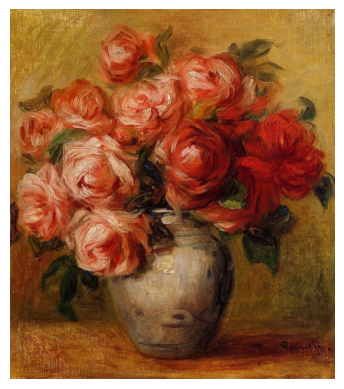

Using seed: 0
[DEBUG] prompt_embeds: torch.Size([4, 77, 4096]), dtype=torch.float16


Stage1 STEP 20 t=0: 100%|██████████| 21/21 [00:00<00:00, 29.04it/s, noise_pred (1, 6, 64, 64) | img (1, 3, 64, 64)]  



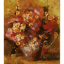
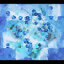

In [49]:
if not is_safe_prompt(input_text_prompt):
    raise ValueError("Inappropriate or unsafe prompt detected.")

print(f"INPUT TEXT: {input_text_prompt}")

prompts = [input_text_prompt]
prompt_embeds = [stage_1.encode_prompt(prompt) for prompt in prompts]
prompt_embeds, negative_prompt_embeds = zip(*prompt_embeds)
prompt_embeds_text = torch.cat(prompt_embeds)
negative_prompt_embeds_text = torch.cat(negative_prompt_embeds)  # These are just null embeds


# views and images_per_view
logo_pil = Image.open(input_image_path).convert("RGB")

print("INPUT IMAGE:")
img_np = np.array(logo_pil)
plt.imshow(img_np)
plt.axis('off')
plt.show()

images_per_view = [logo_pil, None]

seed = 0
print(f"Using seed: {seed}")
generator = torch.Generator(device=device)
generator.manual_seed(seed)

# ---- Stage 1 ----
samples64 = img_sample_stage_1(
    model=stage_1,
    prompt_embeds_text=prompt_embeds_text,
    negative_prompt_embeds_text=negative_prompt_embeds_text,
    views=views,
    images_per_view=images_per_view,
    num_inference_steps=70,
    guidance_scale=8.0,
    reduction='mean',
    strength=0.3,
    generator=generator,
)

mp.show_images([im_to_np(view.view(samples64[0])) for view in views])

In [50]:
del stage_1
flush()
flush()

In [51]:
stage_2 = IFSuperResolutionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0",
    variant="fp16",
    torch_dtype=torch.float16
)

if device == "cpu":
    stage_2.enable_model_cpu_offload()
else:
    stage_2 = stage_2.to(device)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]


[DEBUG] prompt_embeds: torch.Size([4, 77, 4096]), dtype=torch.float16


Stage2 STEP 29 t=0: 100%|██████████| 30/30 [00:08<00:00,  3.70it/s, noise_pred (1, 6, 256, 256) | img (1, 3, 256, 256)]  



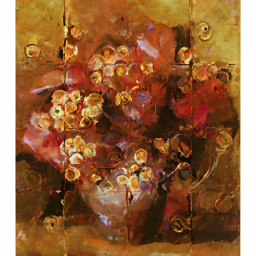
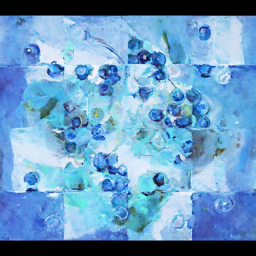

In [52]:
# ---- Stage 2 ----
samples256 = img_sample_stage_2(
    model=stage_2,
    image=samples64,
    prompt_embeds_text=prompt_embeds_text,
    negative_prompt_embeds_text=negative_prompt_embeds_text,
    views=views,
    images_per_view=images_per_view,
    num_inference_steps=30,
    guidance_scale=5.0,
    reduction='mean',
    noise_level=40,
    generator=torch.manual_seed(seed),
)

mp.show_images([im_to_np(view.view(samples256[0])) for view in views])

In [53]:
del stage_2
flush()
flush()

In [54]:
stage_3 = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler",
    torch_dtype=torch.float16
)

if device == "cpu":
    stage_3.enable_model_cpu_offload()
else:
    stage_3 = stage_3.to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


c:\Users\CSE07\Anaconda3\envs\visual_anagrams\lib\site-packages\diffusers\image_processor.py:339: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 75/75 [00:13<00:00,  5.51it/s]



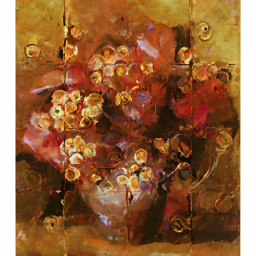
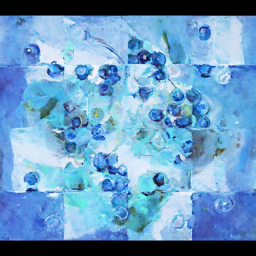

Saved images to: C:\Users\CSE07\Desktop\PW25_SSS_13\FINALflowers_blueberries_CombinedView_0.png and C:\Users\CSE07\Desktop\PW25_SSS_13\FINALflowers_blueberries_CombinedView_1.png
=== Evaluating Visual Anagram ===

Visual Anagram Evaluation Summary
╒═════════════════════════════════╤═════════╤═══════════════╤═══════════════════════════════════════════╕
│ Metric                          │   Value │ Ideal Range   │ Interpretation                            │
╞═════════════════════════════════╪═════════╪═══════════════╪═══════════════════════════════════════════╡
│ CLIP Alignment (View 1)         │  0.2981 │ 0.25 - 0.35   │ Semantic match for View 1                 │
├─────────────────────────────────┼─────────┼───────────────┼───────────────────────────────────────────┤
│ CLIP Alignment (View 2)         │  0.2891 │ 0.25 - 0.35   │ Semantic match for View 2                 │
├─────────────────────────────────┼─────────┼───────────────┼───────────────────────────────────────────┤
│ Cross-Si

100%|██████████| 45/45 [00:45<00:00,  1.01s/it]


Making video...


In [55]:
# ---- Stage 3 ----
image_1024 = stage_3(
        prompt=input_text_prompt,  # Note this is a string, and not an embedding
        image=samples256,
        noise_level=0,
        output_type='pt',
        generator=None).images

image_1024 = image_1024 * 2 - 1

# Save results
temp_images = [im_to_np(view.view(samples256[0])) for view in views]
mp.show_images(temp_images, width=400)

save_image_path = output_image_directory + file_name[:-4] + '_' + type(views[1]).__name__
for j, img in enumerate(temp_images):
    mp.write_image(f"{save_image_path}_{j}.png", img)

print(f"Saved images to: {save_image_path}_0.png and {save_image_path}_1.png")

imgA = f"{save_image_path}_0.png"
imgB = f"{save_image_path}_1.png"
promptA=input_image_caption
promptB=input_text_prompt

results = evaluate_anagram(imgA, promptA, imgB, promptB)

# Get size
im_size = image_1024.shape[-1]
frame_size = int(im_size * 1.5)

# Make save path
save_video_path = output_video_directory + file_name[:-4] + '_' + type(views[1]).__name__ + '_animation.mp4'

# Convert to PIL
pil_image = TF_1.to_pil_image(image_1024[0] / 2. + 0.5)

combined_view = views[1]

animate_two_view(
    pil_image,
    combined_view,
    promptA,
    promptB,
    save_video_path=save_video_path,
    hold_duration=120,
    text_fade_duration=10,
    transition_duration=45,
    im_size=im_size,
    frame_size=frame_size,
)
# # Display the video (using max width of 600 so will fit on most screens)
mp.show_video(mp.read_video(save_video_path), fps=30, width=min(600, frame_size))

if torch.cuda.is_available():
    torch.cuda.empty_cache()